# SARIMA Model - Applied to Rest of Buildings

- In "New_SARIMA_Modeling_Validation", the electricity consumption for building_580 was analyzed.
- A SARIMA model with parameters (1,1,2)x(1,1,2,7) was found to be the most effective.
- This model will now be applied to the rest of the buildings on the UC Berkeley campus this project is looking at.
- To improve model performance, exogenous variables will be considered.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import pickle
import math
import holidays

pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

import sys
import statsmodels as ss
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
with open('Data_Files/berkeley_clean4.pkl','rb') as read_file:
    berkeley_df = pickle.load(read_file)

# Prepare Dataset

## Group by Date

- The SARIMA model does not perform well with volatile (hourly) data, so the electricity consumption for each building will be aggregated into daily sums.

In [4]:
berkeley_date = berkeley_df.groupby(['Date','Month', 'building_id']).agg({'meter_reading_scraped':'sum'}).reset_index()

In [5]:
berkeley_date = berkeley_date.sort_values(by=['building_id','Date']).reset_index(drop=True)

In [6]:
berkeley_date['Date2'] = berkeley_date.Date
berkeley_date = berkeley_date.set_index('Date2')

## Create Exogenous Variable for Future Use

- One obvious idea for improved model performance is to include holidays into the dataset.
- The holiday column will be binary: 1 for holiday, 0 for non-holiday.
- This should improve model performance, as there will likely be less electricity consumption on holidays.

In [7]:
us_holidays = holidays.UnitedStates()

In [8]:
holidays_list = [1 if values in us_holidays else 0 for index, values in berkeley_date['Date'].iteritems()]


In [9]:
berkeley_date.insert(2, column = 'Holiday', value = holidays_list)


In [10]:
building_list = berkeley_date['building_id'].unique()

In [11]:
building_list

array([565, 567, 568, 569, 570, 571, 573, 574, 575, 576, 577, 580, 582,
       583, 584, 585, 586, 587, 588, 589, 592, 594, 595, 597, 598, 599,
       600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 626, 627,
       628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642,
       643, 644, 645, 646, 649, 652, 653, 654, 655])

## Train/Test Split, and Split By Building

In [12]:
train = berkeley_date[(berkeley_date['Date'].values < dt.datetime.strptime('2019-11-01 00:00:00', '%Y-%m-%d %H:%M:%S').date())]
test = berkeley_date[(berkeley_date['Date'].values > dt.datetime.strptime('2019-10-31 00:00:00', '%Y-%m-%d %H:%M:%S').date()) &
                     (berkeley_date['Date'].values < dt.datetime.strptime('2019-11-29 00:00:00', '%Y-%m-%d %H:%M:%S').date())]

In [13]:
# Split dataframe by the 74 buidlings.

def building_df_separator(full_df, building_no):
    
    building_df = full_df[full_df['building_id'] == building_no]
        
    return building_df

In [29]:
berkeley_date_dict = {}
berkeley_train_dict = {}
berkeley_test_dict = {}

for i in building_list:
    berkeley_date_dict[i] = building_df_separator(berkeley_date, i)
    berkeley_train_dict[i] = building_df_separator(train, i)
    berkeley_test_dict[i] = building_df_separator(test, i)

In [15]:
def clean_dict(messy_dict):

    berkeley_clean_dict = {}

    for keys, values in messy_dict.items():
        if keys < 603:
            berkeley_clean_dict[keys] = values
        elif keys > 604 and keys < 618:
            berkeley_clean_dict[keys] = values
        elif keys > 618:
            berkeley_clean_dict[keys] = values
            
    return berkeley_clean_dict

In [30]:
berkeley_clean_date_dict = clean_dict(berkeley_date_dict)
berkeley_clean_train_dict = clean_dict(berkeley_train_dict)
berkeley_clean_test_dict = clean_dict(berkeley_test_dict)

# Modeling/Validation

## Baseline Evaluation

- First run through using the SARIMA model that was optimized for Building 580.
- This will be done using the `sarima_model` function.
- The MAPE will be looked at across all buildings.

In [17]:
def unlog_pred(log_pred):
    
    pred = [math.exp(i) for i in log_pred]
    pred = pd.Series(pred, index = log_pred.index)
    
    return pred

In [18]:
def sarima_model(train_dict, test_dict):
    
    sar_pred_dict = {}
    mae_dict = {}
    
    for keys, values in train_dict.items():
        model = sm.tsa.statespace.SARIMAX(np.log(values.meter_reading_scraped), 
                                    order=(1,1,2), 
                                    seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')
        
        sar_test = test_dict[keys].meter_reading_scraped.values
        
        sar_pred_log = model.get_forecast(steps = 28)
        sar_pred = unlog_pred(sar_pred_log.predicted_mean)
        
        mae_pred = np.array(sar_pred.values)

        mae_score = (abs(sar_test-mae_pred)/sar_test)*100
        mae_mean = mae_score.mean()
        mae_dict[keys] = mae_mean
        print('Building: ', keys)
        print('Mean Absolute Error: ', mae_mean)
        
    return sar_pred_dict, mae_dict

In [19]:
sar_pred_dict1, mae_dict1 = sarima_model(berkeley_clean_train_dict, berkeley_clean_test_dict)

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.703961
         Iterations: 3
         Function evaluations: 282
Building:  565
Mean Absolute Error:  10.22948304453867


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.398882
         Iterations: 10
         Function evaluations: 893
Building:  567
Mean Absolute Error:  6.235715630973444


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.282389
         Iterations: 5
         Function evaluations: 464
Building:  568
Mean Absolute Error:  11.548344329653023


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.250118
         Iterations: 5
         Function evaluations: 466
Building:  569
Mean Absolute Error:  13.814295203510921


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: -1.177962
         Iterations: 15
         Function evaluations: 1415
Building:  570
Mean Absolute Error:  5.423107478353293


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.349800
         Iterations: 17
         Function evaluations: 1749
Building:  571
Mean Absolute Error:  22.06822136965659


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.006969
         Iterations: 12
         Function evaluations: 1161
Building:  573
Mean Absolute Error:  8.17013213536855


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.197739
         Iterations: 13
         Function evaluations: 1263
Building:  574
Mean Absolute Error:  17.08439606246198


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.030101
         Iterations: 12
         Function evaluations: 1098
Building:  575
Mean Absolute Error:  7.527339538120141


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.558155
         Iterations: 4
         Function evaluations: 377
Building:  576
Mean Absolute Error:  14.025032258622232


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.493028
         Iterations: 6
         Function evaluations: 510
Building:  577
Mean Absolute Error:  9.658819251365676


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.792254
         Iterations: 15
         Function evaluations: 1317
Building:  580
Mean Absolute Error:  9.2256333536524


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.329129
         Iterations: 12
         Function evaluations: 1055
Building:  582
Mean Absolute Error:  4.391960194039492


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.213861
         Iterations: 7
         Function evaluations: 667
Building:  583
Mean Absolute Error:  0.9749299855970771


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.980831
         Iterations: 3
         Function evaluations: 277
Building:  584
Mean Absolute Error:  7.987324421843673


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.842319
         Iterations: 3
         Function evaluations: 293
Building:  585
Mean Absolute Error:  8.36164260819148


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.327647
         Iterations: 15
         Function evaluations: 1899
Building:  586
Mean Absolute Error:  16.273140256792118


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.254815
         Iterations: 5
         Function evaluations: 491
Building:  587
Mean Absolute Error:  14.778333692356211


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.774671
         Iterations: 3
         Function evaluations: 291
Building:  588
Mean Absolute Error:  13.930823740750098


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.850974
         Iterations: 11
         Function evaluations: 1034
Building:  589
Mean Absolute Error:  10.798384576742974


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.933448
         Iterations: 5
         Function evaluations: 495
Building:  592
Mean Absolute Error:  2.76233467295048


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.972655
         Iterations: 3
         Function evaluations: 290
Building:  594
Mean Absolute Error:  3.541432623826759


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.945858
         Iterations: 3
         Function evaluations: 273
Building:  595
Mean Absolute Error:  6.893310974787228


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.762726
         Iterations: 12
         Function evaluations: 1084
Building:  597
Mean Absolute Error:  13.597399862633955


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.356608
         Iterations: 3
         Function evaluations: 276
Building:  598
Mean Absolute Error:  0.44252732731783706


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.288006
         Iterations: 9
         Function evaluations: 825
Building:  599
Mean Absolute Error:  18.34691669166483


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.444571
         Iterations: 10
         Function evaluations: 921
Building:  600
Mean Absolute Error:  7.340483068547376


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.217497
         Iterations: 8
         Function evaluations: 755
Building:  601
Mean Absolute Error:  90.18449939455844


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.813190
         Iterations: 3
         Function evaluations: 270
Building:  602
Mean Absolute Error:  14.928290854248102


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.514584
         Iterations: 11
         Function evaluations: 1086
Building:  605
Mean Absolute Error:  16.855483557562604


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.450927
         Iterations: 7
         Function evaluations: 689
Building:  606
Mean Absolute Error:  3.885556814295717


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.946102
         Iterations: 6
         Function evaluations: 551
Building:  607
Mean Absolute Error:  7.860637491783763


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.403569
         Iterations: 3
         Function evaluations: 272
Building:  608
Mean Absolute Error:  4.968498260503919


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.000119
         Iterations: 6
         Function evaluations: 600
Building:  609
Mean Absolute Error:  5.250620309503115


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.003003
         Iterations: 20
         Function evaluations: 1735
Building:  610
Mean Absolute Error:  32.605910155758565


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.255516
         Iterations: 7
         Function evaluations: 683
Building:  611
Mean Absolute Error:  3.9234214097663043


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.309190
         Iterations: 5
         Function evaluations: 502
Building:  612
Mean Absolute Error:  6.126824320390502


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.690920
         Iterations: 3
         Function evaluations: 282
Building:  614
Mean Absolute Error:  5.416571253361766


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.090246
         Iterations: 5
         Function evaluations: 507
Building:  615
Mean Absolute Error:  4.149464417439645


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.098351
         Iterations: 2
         Function evaluations: 175
Building:  616
Mean Absolute Error:  6.853452595946576


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.141487
         Iterations: 5
         Function evaluations: 472
Building:  617
Mean Absolute Error:  4.694904660553354


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.106613
         Iterations: 15
         Function evaluations: 1462
Building:  619
Mean Absolute Error:  5.50651296147638


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.760902
         Iterations: 6
         Function evaluations: 573
Building:  620
Mean Absolute Error:  8.800955727064432


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.728532
         Iterations: 4
         Function evaluations: 357
Building:  621
Mean Absolute Error:  11.335164390858248


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.299456
         Iterations: 3
         Function evaluations: 291
Building:  622
Mean Absolute Error:  3.411586197015894


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.917371
         Iterations: 7
         Function evaluations: 671
Building:  623
Mean Absolute Error:  11.123823547657611


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.198264
         Iterations: 4
         Function evaluations: 379
Building:  624
Mean Absolute Error:  11.855803763114022


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.851267
         Iterations: 5
         Function evaluations: 463
Building:  626
Mean Absolute Error:  17.91025457810977


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.004499
         Iterations: 8
         Function evaluations: 765
Building:  627
Mean Absolute Error:  7.709966125694785


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.215191
         Iterations: 4
         Function evaluations: 375
Building:  628
Mean Absolute Error:  6.121004818384533


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.416540
         Iterations: 6
         Function evaluations: 585
Building:  630
Mean Absolute Error:  7.672333286455311


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.866588
         Iterations: 5
         Function evaluations: 467
Building:  631
Mean Absolute Error:  12.0366396026865


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.652764
         Iterations: 9
         Function evaluations: 854
Building:  632
Mean Absolute Error:  4.554904302810843


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.967650
         Iterations: 3
         Function evaluations: 311
Building:  633
Mean Absolute Error:  0.8490006570481939


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.182960
         Iterations: 7
         Function evaluations: 641
Building:  634
Mean Absolute Error:  35.59385645539392


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.124909
         Iterations: 10
         Function evaluations: 926
Building:  635
Mean Absolute Error:  12.322321999953003


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.203460
         Iterations: 7
         Function evaluations: 658
Building:  636
Mean Absolute Error:  27.306796275517122


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.441925
         Iterations: 12
         Function evaluations: 1120
Building:  637
Mean Absolute Error:  13.111338686247036


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.628009
         Iterations: 7
         Function evaluations: 651
Building:  638
Mean Absolute Error:  9.577607678348736


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.505600
         Iterations: 13
         Function evaluations: 1197
Building:  640
Mean Absolute Error:  9.31225123763849


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.737270
         Iterations: 6
         Function evaluations: 608
Building:  641
Mean Absolute Error:  4.77777492247097


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.716322
         Iterations: 3
         Function evaluations: 283
Building:  642
Mean Absolute Error:  13.076976980143245


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.340668
         Iterations: 5
         Function evaluations: 475
Building:  643
Mean Absolute Error:  5.052057436194109


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.727315
         Iterations: 6
         Function evaluations: 549
Building:  644
Mean Absolute Error:  16.708313136371004


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.668900
         Iterations: 5
         Function evaluations: 455
Building:  645
Mean Absolute Error:  3.252037277722206


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.670345
         Iterations: 3
         Function evaluations: 272
Building:  646
Mean Absolute Error:  8.4836203815275


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.410457
         Iterations: 6
         Function evaluations: 545
Building:  649
Mean Absolute Error:  5.529991126799834


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.680702
         Iterations: 13
         Function evaluations: 1199
Building:  652
Mean Absolute Error:  20.281152514552183


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.737719
         Iterations: 6
         Function evaluations: 580
Building:  653
Mean Absolute Error:  5.371377861207207


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.175671
         Iterations: 3
         Function evaluations: 284
Building:  654
Mean Absolute Error:  1.7486515383635985


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.818802
         Iterations: 9
         Function evaluations: 852
Building:  655
Mean Absolute Error:  10.835903401769162


8.36164260819148


(array([40., 25.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.44252733,  9.41672453, 18.39092174, 27.36511895, 36.33931615,
        45.31351336, 54.28771057, 63.26190777, 72.23610498, 81.21030219,
        90.18449939]),
 <a list of 10 Patch objects>)

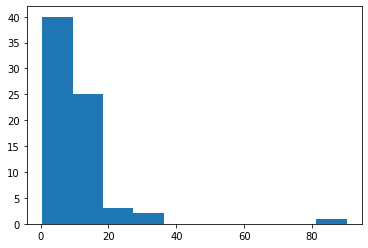

In [23]:
mae_list1 = list(mae_dict1.values())
print(np.median(mae_list1))
plt.hist(mae_list1)

In [44]:
mae_list_10 = [i for i in mae_list1 if i < 10]

**42/71 (59%) of the buildings have a MAPE of 10% or less, and the median MAPE is 8.36%. This is not bad for the first run through! Next step is adding in an exogenous variable for improved model performance.**

## Model with Exogenous Variable

In [24]:
pred_index = [pd.to_datetime('2019-11-01')]
add_day = pd.to_datetime('2019-11-01')
i = 0
for i in range(27):
    add_day += timedelta(days=1)
    add_day_list = [add_day]
    pred_index.extend(add_day_list)
    i += 1

In [25]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

In [33]:
def train_test_validation(data, n_test): # data is array of all values
    
    predictions = []
    mae_list = []
    
    X = np.log(data.meter_reading_scraped.values)
    ex = data.Holiday.values
    first_df = data[data['Date'] < pd.to_datetime('2019-11-01')]
    last_df = data[(data['Date'] >= pd.to_datetime('2019-11-01')) & (data['Date'] < pd.to_datetime('2019-11-29'))]
    first_index = list(first_df.Date.values)
    last_index = list(last_df.Date.values)
    train, test = train_test_split(X, n_test)
    train_ex, test_ex = train_test_split(ex, n_test)
    test, test_ex = test[:-2], test_ex[:-2]
    train_ser, train_ex_ser = pd.Series(train, index = first_index), pd.Series(train_ex, index = first_index)
    test_ser, test_ex_ser = pd.Series(test, index = last_index), pd.Series(test_ex, index = last_index)
    
    
    model = sm.tsa.statespace.SARIMAX(train_ser, train_ex_ser, order=(1,1,2), 
                                                seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')

#     log_pred = model.predict(pd.to_datetime('2019-11-01'), pd.to_datetime('2019-11-28'), exog = pd.DataFrame(test_ex_ser))
#     sar_pred = unlog_pred(log_pred)
    sar_test = unlog_pred(test_ser)

    pred_forecast_log = model.get_forecast(steps = 28, exog = pd.DataFrame(test_ex_ser))
    pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)
    
    mae_pred = np.array(pred_forecast.values)
    mae_test = np.array(sar_test.values)

    mae_score = (abs(mae_test-mae_pred)/mae_test)*100
    mae_mean = mae_score.mean()
    print('Building: ', key)
    print('Mean Absolute Error: ', mae_mean)

    return pred_forecast, mae_mean

In [37]:
sar_pred_dict_ex = {}
mae_dict_ex = {}

for key in berkeley_clean_train_dict.keys():
    
    ex_pred, ex_mae = train_test_validation(berkeley_clean_date_dict[key], 1400)
    sar_pred_dict_ex[key] = ex_pred
    mae_dict_ex[key] = ex_mae


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.825450
         Iterations: 3
         Function evaluations: 287
Building:  565
Mean Absolute Error:  8.025521553069797


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.408870
         Iterations: 8
         Function evaluations: 802
Building:  567
Mean Absolute Error:  5.898226749271003


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.368017
         Iterations: 4
         Function evaluations: 404
Building:  568
Mean Absolute Error:  8.529171544610213


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.252854
         Iterations: 5
         Function evaluations: 506
Building:  569
Mean Absolute Error:  13.5803940529227


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.395078
         Iterations: 3
         Function evaluations: 309
Building:  570
Mean Absolute Error:  3.0312134110914064


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.589266
         Iterations: 4
         Function evaluations: 396
Building:  571
Mean Absolute Error:  10.861202081502826


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.065571
         Iterations: 12
         Function evaluations: 1232
Building:  573
Mean Absolute Error:  6.568120114983316


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.414114
         Iterations: 13
         Function evaluations: 1314
Building:  574
Mean Absolute Error:  7.4663087881154295


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.037894
         Iterations: 15
         Function evaluations: 1507
Building:  575
Mean Absolute Error:  7.544376045104117


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.564311
         Iterations: 4
         Function evaluations: 397
Building:  576
Mean Absolute Error:  14.101292749656448


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.480382
         Iterations: 6
         Function evaluations: 580
Building:  577
Mean Absolute Error:  6.68767603720531


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.897288
         Iterations: 6
         Function evaluations: 647
Building:  580
Mean Absolute Error:  7.03993307211062


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.362776
         Iterations: 11
         Function evaluations: 1087
Building:  582
Mean Absolute Error:  3.7413194278628485


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.274778
         Iterations: 7
         Function evaluations: 736
Building:  583
Mean Absolute Error:  1.1086219388687382


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.083029
         Iterations: 3
         Function evaluations: 312
Building:  584
Mean Absolute Error:  6.075458053758289


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.938880
         Iterations: 3
         Function evaluations: 326
Building:  585
Mean Absolute Error:  7.455921998797855


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.582252
         Iterations: 4
         Function evaluations: 398
Building:  586
Mean Absolute Error:  8.609810268266296


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.290874
         Iterations: 6
         Function evaluations: 626
Building:  587
Mean Absolute Error:  14.700846725236238


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.799645
         Iterations: 3
         Function evaluations: 297
Building:  588
Mean Absolute Error:  14.465975117465149


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.056766
         Iterations: 8
         Function evaluations: 850
Building:  589
Mean Absolute Error:  5.862933568232257


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.960412
         Iterations: 4
         Function evaluations: 438
Building:  592
Mean Absolute Error:  2.6849482913703553


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.071668
         Iterations: 11
         Function evaluations: 1116
Building:  594
Mean Absolute Error:  3.0588751893210913


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.118507
         Iterations: 3
         Function evaluations: 290
Building:  595
Mean Absolute Error:  4.171217494199035


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.823600
         Iterations: 17
         Function evaluations: 1732
Building:  597
Mean Absolute Error:  13.628921245122475


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.488941
         Iterations: 3
         Function evaluations: 301
Building:  598
Mean Absolute Error:  1.2744528885715063


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.289980
         Iterations: 6
         Function evaluations: 599
Building:  599
Mean Absolute Error:  17.9714113442847


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.480845
         Iterations: 11
         Function evaluations: 1110
Building:  600
Mean Absolute Error:  6.785002871808779


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.217491
         Iterations: 8
         Function evaluations: 827
Building:  601
Mean Absolute Error:  90.25789114181362


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.813604
         Iterations: 3
         Function evaluations: 293
Building:  602
Mean Absolute Error:  14.862812692926274


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.765886
         Iterations: 14
         Function evaluations: 1367
Building:  605
Mean Absolute Error:  9.547975246676511


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.484083
         Iterations: 7
         Function evaluations: 737
Building:  606
Mean Absolute Error:  3.8807839541635087


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.006041
         Iterations: 15
         Function evaluations: 1594
Building:  607
Mean Absolute Error:  7.586347475313046


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.519149
         Iterations: 3
         Function evaluations: 320
Building:  608
Mean Absolute Error:  3.737594169869165


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.007154
         Iterations: 5
         Function evaluations: 540
Building:  609
Mean Absolute Error:  5.192200843833061


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.006750
         Iterations: 19
         Function evaluations: 1825
Building:  610
Mean Absolute Error:  30.9321943416774


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.281432
         Iterations: 6
         Function evaluations: 636
Building:  611
Mean Absolute Error:  3.5266979964912926


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.385194
         Iterations: 5
         Function evaluations: 526
Building:  612
Mean Absolute Error:  6.264979562725728


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.880011
         Iterations: 3
         Function evaluations: 288
Building:  614
Mean Absolute Error:  4.287030746800004


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.122538
         Iterations: 5
         Function evaluations: 538
Building:  615
Mean Absolute Error:  3.9214905355019316


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.216747
         Iterations: 3
         Function evaluations: 336
Building:  616
Mean Absolute Error:  5.018967987380448


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.166370
         Iterations: 5
         Function evaluations: 527
Building:  617
Mean Absolute Error:  4.638643372622531


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.106266
         Iterations: 15
         Function evaluations: 1595
Building:  619
Mean Absolute Error:  5.480164635332376


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.763029
         Iterations: 5
         Function evaluations: 520
Building:  620
Mean Absolute Error:  8.810051404929386


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.773315
         Iterations: 4
         Function evaluations: 400
Building:  621
Mean Absolute Error:  9.513664642463352


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.421651
         Iterations: 8
         Function evaluations: 839
Building:  622
Mean Absolute Error:  3.2216392724976664


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.125938
         Iterations: 13
         Function evaluations: 1314
Building:  623
Mean Absolute Error:  7.789841798433692


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.242253
         Iterations: 8
         Function evaluations: 813
Building:  624
Mean Absolute Error:  10.844477916550607


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.882657
         Iterations: 5
         Function evaluations: 504
Building:  626
Mean Absolute Error:  16.394132938254565


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.090827
         Iterations: 4
         Function evaluations: 402
Building:  627
Mean Absolute Error:  7.940791897894736


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.325260
         Iterations: 9
         Function evaluations: 977
Building:  628
Mean Absolute Error:  5.522753555358846


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.664286
         Iterations: 12
         Function evaluations: 1254
Building:  630
Mean Absolute Error:  3.7966690742013185


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.962005
         Iterations: 5
         Function evaluations: 504
Building:  631
Mean Absolute Error:  9.518636047575539


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.737907
         Iterations: 11
         Function evaluations: 1141
Building:  632
Mean Absolute Error:  3.930689242181295


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.993806
         Iterations: 3
         Function evaluations: 335
Building:  633
Mean Absolute Error:  0.7460797383216116


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.239943
         Iterations: 13
         Function evaluations: 1282
Building:  634
Mean Absolute Error:  35.799604148179604


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.146575
         Iterations: 10
         Function evaluations: 1010
Building:  635
Mean Absolute Error:  11.89078880301409


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.238445
         Iterations: 6
         Function evaluations: 601
Building:  636
Mean Absolute Error:  26.3695580030035


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.482835
         Iterations: 13
         Function evaluations: 1332
Building:  637
Mean Absolute Error:  14.175342448243791


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.682078
         Iterations: 6
         Function evaluations: 611
Building:  638
Mean Absolute Error:  7.614708194266727


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.525271
         Iterations: 13
         Function evaluations: 1324
Building:  640
Mean Absolute Error:  9.00731951801855


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.755592
         Iterations: 6
         Function evaluations: 642
Building:  641
Mean Absolute Error:  4.726401236624421


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.853231
         Iterations: 15
         Function evaluations: 1528
Building:  642
Mean Absolute Error:  10.829628734035879


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.581231
         Iterations: 5
         Function evaluations: 523
Building:  643
Mean Absolute Error:  3.069760731126337


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.735553
         Iterations: 6
         Function evaluations: 597
Building:  644
Mean Absolute Error:  16.941210007132685


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.673236
         Iterations: 5
         Function evaluations: 508
Building:  645
Mean Absolute Error:  3.220995092535021


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.890854
         Iterations: 4
         Function evaluations: 394
Building:  646
Mean Absolute Error:  5.313615568564637


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.412114
         Iterations: 6
         Function evaluations: 610
Building:  649
Mean Absolute Error:  5.52205618062591


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.926096
         Iterations: 3
         Function evaluations: 331
Building:  652
Mean Absolute Error:  19.469216677449765


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -1.744484
         Iterations: 6
         Function evaluations: 629
Building:  653
Mean Absolute Error:  5.366619908872537


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -2.214764
         Iterations: 3
         Function evaluations: 316
Building:  654
Mean Absolute Error:  1.501555061118913


/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.836566
         Iterations: 11
         Function evaluations: 1112
Building:  655
Mean Absolute Error:  9.94013530872061


7.03993307211062


(array([51., 15.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.74607974,  9.69726088, 18.64844202, 27.59962316, 36.5508043 ,
        45.50198544, 54.45316658, 63.40434772, 72.35552886, 81.30671   ,
        90.25789114]),
 <a list of 10 Patch objects>)

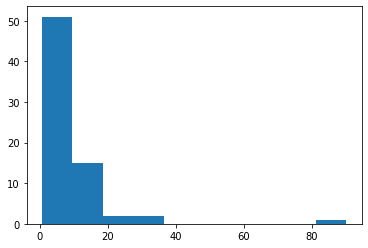

In [38]:
mae_list_ex = list(mae_dict_ex.values())
print(np.median(mae_list_ex))
plt.hist(mae_list_ex)

**52/71 (73%) of the buildings have a MAPE of 10% or less, and the median MAPE is 7.04%. This is an almost 20% improvement on the baseline evaluation!**

## Save Data

The predictions will be saved into pickle files so that they can be used in the "New_SARIMA_Presentation_Prep" notebook. The findings here will be consolidated, exported, and used in Tableau for data visualizations.

In [ ]:
# sar_pred_dict1 = {}

# for keys, values in sar_pred_dict.items():
#     sar_pred_dict1[keys] = values[1]

In [319]:
with open('sar_pred_dict_month_R1.pkl', 'wb') as to_write:
    pickle.dump(sar_pred_dict1, to_write)

In [318]:
with open('mae_dict_month_R1.pkl', 'wb') as to_write:
    pickle.dump(mae_dict1, to_write)

---

In [49]:
# for pred in sar_pred_list:
#     with open('Model_Pickles/{}.pkl'.format(list(pred.keys())[0]), 'wb') as to_write:
#         pickle.dump(pred, to_write)

In [50]:
# unfit_buildings = [(keys, values) for keys, values in mae_dict.items() if values > 20]
        

In [51]:
# unfit_buildings

---

In [ ]:
# df = berkeley_date_dict[565].Holiday

# df.loc[pd.to_datetime('2019-11-01'): pd.to_datetime('2019-11-01') + timedelta(days=7)]

In [ ]:
# # walk forward validation in a step by step manner
# def walk_forward_validation(data, n_test, end_date): # data is array of all values
    
#     predictions = []
#     mae_list = []
    
#     X = np.log(data.meter_reading_scraped.values)
#     first_df = data[data['Date'] < pd.to_datetime(end_date)]
#     first_index = list(first_df.Date.values)
#     train, test = train_test_split(X, n_test)
#     history = [x for x in train] #seed history with training data
    
#     week_list = [7,14,21,28]
#     for index, week in enumerate(week_list):  
        
#         j = week-7
#         model = sm.tsa.statespace.SARIMAX(pd.Series(history, index = first_index), order=(1,1,2), 
#                                                     seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')
        
#         log_pred = model.predict(pd.to_datetime('2018-12-31'), pd.to_datetime(end_date))
#         sar_pred = unlog_pred(log_pred)
        
#         pred_forecast_log = model.get_forecast(steps = 7)
#         pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)
#         predictions = np.concatenate((predictions, pred_forecast), axis=None)
        
#         mae_test = np.array([math.exp(num) for num in test[j:week]])
#         mae_score = (abs(mae_test-predictions[j:week])/mae_test)*100
#         mae_mean = mae_score.mean()
#         print(mae_mean)
#         mae_list.append(mae_mean)
#         print('-------------------')
                                          
#         history = np.concatenate((history, test[j:week]), axis=None) #add it to history for next loop
#         end_date = pd.to_datetime(end_date) + timedelta(days=7)
        
#         day = 0
#         for day in range(7):
#             add_day = [first_index[-1] + timedelta(days=1)]
#             first_index.extend(add_day)
#             day += 1
    
#     mae = np.array(mae_list).mean()
    
#     sar_preds = pd.Series(predictions, index = pred_index)
#     print('Building', i, ':')
#     print('Mean Absolute Error:', mae)
#     print('-------------------')    
#     print('-------------------')
                    
#     return sar_preds, mae